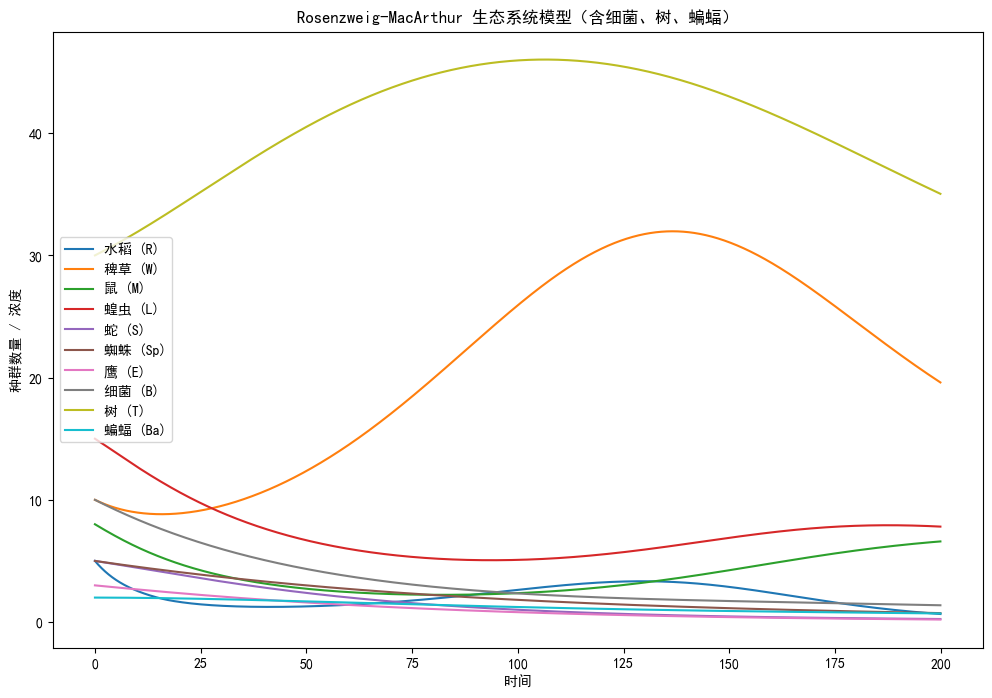

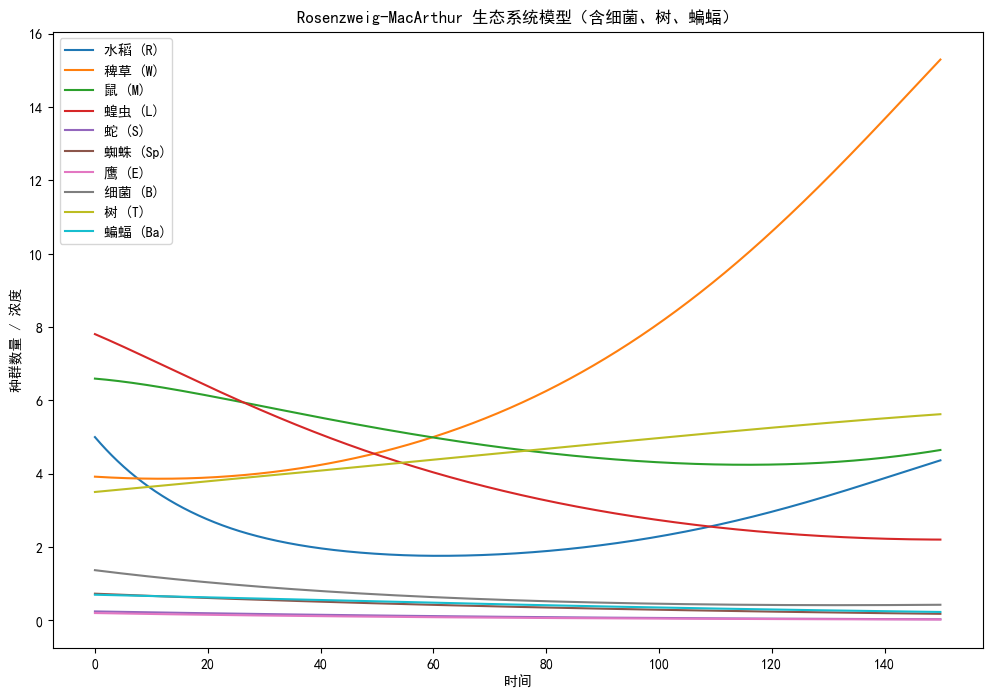

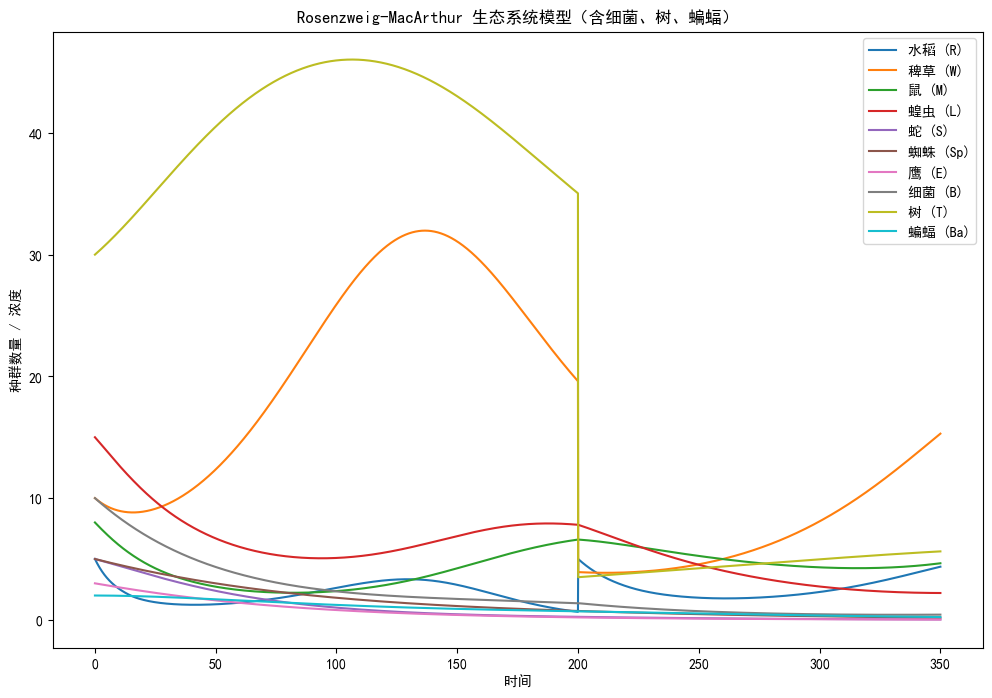

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 在原有的 9 个物种基础上添加第 10 个物种“蝙蝠 (Ba)”，只捕食蝗虫 (L)。
def fret_func(x,t):
    if x <= 0.5:
        return (1 + 1.6* x**2)*np.exp(-t/200)  # 递增部分
    else:
        return 1.4 * np.exp(-10 * (x - 0.5))*np.exp(-t/200)
def rosenzweig_macarthur_with_bacteria_tree_bat(t, y, params):
    """
    修改版生态系统动力学模型，包含 10 个物种：
    R (水稻), W (稗草), M (鼠), L (蝗虫), S (蛇),
    Sp (蜘蛛), E (鹰), B (细菌), T (树), Ba (蝙蝠).
    Ba 只捕食 L。
    """
    # 解包状态变量
    R, W, M, L, S, Sp, E, B_, T_, Ba = y

    (
        # ------------------- 原有参数 -------------------
        rR, KR, rW, KW,
        aRM, bRM, eMR, aWM, bWM, eMW,
        aRL, bRL, eLR, aWL, bWL, eLW,
        aSM, bSM, eSM, aSL, bSL, eSL,
        aSpL, bSpL, eSpL,
        aES, bES, eES, aESp, bESp, eESp, aEM, bEM, eEM,
        aBR, bBR, eRB, aBW, bBW, eWB,
        alphaB, dR, dW, dM, dL, dS, dSp, dE, dB,
        rT, KT, aTM, bTM, eTM, aTL, bTL, eTL, dT,
        # ------------------- 新增蝙蝠相关参数 -------------------
        aBaL, bBaL, eBaL, dBa,
        fret # 肥料参数
    ) = params
    bat_par=[0.01, 0.01, 0.01]
    #------------------- 与原有物种相关的计算 -------------------
    # 1) 水稻 R
    cons_R_by_M = (aRM * R * M) / (1.0 + bRM * R)
    cons_R_by_L = (aRL * R * L) / (1.0 + bRL * R)
    cons_B_by_R = (aBR * B_ * R) / (1.0 + bBR * B_)
    gain_R_from_B = eRB * cons_B_by_R
    #  蝙蝠的影响, 肥料的影响
    rR+=bat_par[0]*Ba*fret_func(x=fret,t=t)
    dRdt = rR * R * (1 - R / KR) + gain_R_from_B - cons_R_by_M - cons_R_by_L - dR * R

    # 2) 稗草 W
    cons_W_by_M = (aWM * W * M) / (1.0 + bWM * W)
    cons_W_by_L = (aWL * W * L) / (1.0 + bWL * W)
    cons_B_by_W = (aBW * B_ * W) / (1.0 + bBW * B_)
    gain_W_from_B = eWB * cons_B_by_W
    #  蝙蝠的影响
    rW+=bat_par[1]*Ba*fret_func(x=fret,t=t)
    dWdt = rW * W * (1 - W / KW) + gain_W_from_B - cons_W_by_M - cons_W_by_L - dW * W

    # 3) 树 T
    cons_T_by_M = (aTM * T_ * M) / (1.0 + bTM * T_)
    cons_T_by_L = (aTL * T_ * L) / (1.0 + bTL * T_)
    gain_M_from_T = eTM * cons_T_by_M
    gain_L_from_T = eTL * cons_T_by_L
    #  蝙蝠的影响
    rT+=bat_par[2]*Ba*fret_func(x=fret,t=t)
    dTdt = rT * T_ * (1 - T_ / KT) - cons_T_by_M - cons_T_by_L - dT * T_

    # 4) 鼠 M
    gain_M_from_R = eMR * cons_R_by_M
    gain_M_from_W = eMW * cons_W_by_M
    cons_M_by_S = (aSM * M * S) / (1.0 + bSM * M)
    cons_M_by_E = (aEM * M * E) / (1.0 + bEM * M)
    dMdt = gain_M_from_R + gain_M_from_W + gain_M_from_T - cons_M_by_S - cons_M_by_E - dM * M

    # 5) 蝗虫 L
    gain_L_from_R = eLR * cons_R_by_L
    gain_L_from_W = eLW * cons_W_by_L
    cons_L_by_S = (aSL * L * S) / (1.0 + bSL * L)
    cons_L_by_Sp = (aSpL * L * Sp) / (1.0 + bSpL * L)
    # 蝙蝠捕食蝗虫
    cons_L_by_Ba = (aBaL * L * Ba) / (1.0 + bBaL * L)
    dLdt = (gain_L_from_R + gain_L_from_W + gain_L_from_T
            - cons_L_by_S - cons_L_by_Sp
            - cons_L_by_Ba
            - dL * L)

    # 6) 蛇 S
    gain_S_from_M = eSM * cons_M_by_S
    gain_S_from_L = eSL * cons_L_by_S
    cons_S_by_E = (aES * S * E) / (1.0 + bES * S)
    dSdt = gain_S_from_M + gain_S_from_L - cons_S_by_E - dS * S

    # 7) 蜘蛛 Sp
    gain_Sp_from_L = eSpL * cons_L_by_Sp
    cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)
    dSpdt = gain_Sp_from_L - cons_Sp_by_E - dSp * Sp

    # 8) 鹰 E
    gain_E_from_S = eES * cons_S_by_E
    gain_E_from_Sp = eESp * cons_Sp_by_E
    gain_E_from_M = eEM * cons_M_by_E
    dEdt = gain_E_from_S + gain_E_from_Sp + gain_E_from_M - dE * E

    # 9) 细菌 B
    total_death_flux = (
        dR * R + dW * W + dM * M +
        dL * L + dS * S + dSp * Sp +
        dE * E + dT * T_
    )
    bacteria_growth = alphaB * total_death_flux
    dBdt = bacteria_growth - dB * B_

    # 10) 蝙蝠 Ba
    # 仅捕食蝗虫，获得能量
    gain_Ba_from_L = eBaL * cons_L_by_Ba
    # 自然死亡率 dBa
    dBadt = gain_Ba_from_L - dBa * Ba

    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt, dBdt, dTdt, dBadt]


def generate_value_bat(pars, init_val, t_end, points_interval):
    t_span = (0, t_end)
    t_eval = np.arange(0, t_end, points_interval)
    sol = solve_ivp(rosenzweig_macarthur_with_bacteria_tree_bat,
                    t_span, init_val, args=(pars,),
                    t_eval=t_eval, method='RK45')
    return sol


def my_plot_bat(sol):
    """ 在图表中包含新加入的蝙蝠 (Ba) 种群 """
    plt.rcParams['font.family'] = 'SimHei'
    plt.figure(figsize=(12, 8))
    plt.xlabel('时间')
    plt.ylabel('种群数量 / 浓度')
    plt.title('Rosenzweig-MacArthur 生态系统模型（含细菌、树、蝙蝠）')

    labels = [
        '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)', '蛇 (S)',
        '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)', '树 (T)', '蝙蝠 (Ba)'
    ]
    for i, label in enumerate(labels):
        plt.plot(sol.t, sol.y[i], label=label)

    plt.legend()
    plt.show()
def my_plot_yt(y,t):
    plt.rcParams['font.family'] = 'SimHei'
    plt.figure(figsize=(12, 8))
    plt.xlabel('时间')
    plt.ylabel('种群数量 / 浓度')
    plt.title('Rosenzweig-MacArthur 生态系统模型（含细菌、树、蝙蝠）')
    labels = [
        '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)', '蛇 (S)',
        '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)', '树 (T)', '蝙蝠 (Ba)'
    ]
    for i, label in enumerate(labels):
        plt.plot(t, y[i], label=label)
    plt.legend()
    plt.show()
def from_forest_modified():
    """
    举例：
    1) 提升捕食速率 aRM, aRL, aSM, aSL 等，让捕食更加剧烈。
    2) 程度更高的收割，进一步削减资源。
    """
    par = (
        0.08, 150,       # rR, KR
        0.05, 150,       # rW, KW
        # 提高捕食速率，舉例: aRM=0.007, aRL=0.007, aSM=0.006
        0.007, 0.001, 0.2,
        0.003, 0.001, 0.2,
        0.007, 0.001, 0.2,
        0.003, 0.001, 0.2,
        0.006, 0.005, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.2,
        0.001, 0.001, 0.1,
        0.001, 0.001, 0.1,
        0.02,                # alphaB
        0.02, 0.015, 0.01, 0.015, 0.02, 0.01, 0.015, 0.02,  # dR, dW, dM, dL, dS, dSp, dE, dB
        0.02, 150,           # rT, KT
        0.0005, 0.001, 0.2,
        0.0005, 0.001, 0.2,
        0.015,               # dT
        0.003, 0.001, 0.22, 0.01,  # aBaL, bBaL, eBaL, dBa
        0.0                  # 额外参数
    )

    # 降低初始的生产者数量，让消费者种群不会一开始就被大量生产者“淹没”
    init_val0 = [5, 10, 8, 15, 5, 5, 3, 10, 30, 2]
    sol_0 = generate_value_bat(par, init_val0, 200, 0.1)
    my_plot_bat(sol_0)

    # 显示“收割/开垦”情景：进一步大幅削减生产者，使消费者出现显著波动
    stage2_init0 = sol_0.y[:, -1].copy()
    stage2_init0[8] *= 0.1  # 更剧烈减少 Trees
    stage2_init0[1] *= 0.2  # 大幅减少 Weeds
    stage2_init0[0] = 5     # 再种一些 Rice
    sol_stage2 = generate_value_bat(par, stage2_init0, 150, 0.1)
    my_plot_bat(sol_stage2)

    # 合并结果
    y12 = np.hstack((sol_0.y, sol_stage2.y))
    t12 = np.linspace(0, 350, y12.shape[1])
    my_plot_yt(y12, t12)
from_forest_modified()